In [1]:
# these are for implementing a progress bar to watch when waiting
from IPython.display import clear_output

In [2]:
import block_methods as BM

from Lanczos_FA.lanczos_bin import *

import numpy as np
# import scipy as sp
import matplotlib.pyplot as plt
from scipy import integrate
import warnings

plt.rcParams["figure.figsize"] = (16,9)
warnings.filterwarnings("ignore")

# for reproducibility on V
np.random.seed(0)

In [3]:
def oscTest(H, w):
    HwI = H-w*np.identity(np.shape(H)[0])
    EvalH, EvecH = np.linalg.eigh(H)
    
    for i in np.arange(len(EvalH)):
        if EvalH[i] <= 0:
            print("Oscilitory behavior is expected for this pair of H and w.")
            return False
    
    return True

In [4]:
def Q_wz(w,z,lmin,lmax):
    """
    max_{x\in[lmin,lmax]} |x-w|/|z-w|
    """
    
    if np.real(z) - w != 0:
        b_hat = ( np.abs(z)**2 - np.real(z)*w ) / (np.real(z) - w)
    else:
        b_hat = np.inf
    
    if lmin < b_hat <= lmax:
        return np.abs((z-w)/np.imag(z))
    else:
        return np.max([np.abs((lmax-w)/(lmax-z)), np.abs((lmin-w)/(lmin-z))])

In [5]:
def block_a_posteriori_bound(T, f,gamma,endpts,w,lmin,lmax, k, B_0):
    """
    (1/2pi) \oint_{\Gamma} |f(z)| |D_{k,w,z}| Q_{w,z} |dz|
    """
    Eval, Evec = np.linalg.eigh(T)
    def F(t):
        z,dz = gamma(t)
        
        return (1/(2*np.pi)) * np.abs(f(z)) * np.linalg.norm(BM.get_CwinvCz(Eval,Evec,z,w,np.shape(B_0)[0],B_0), ord = 2) * Q_wz(w,z,lmin,lmax) * np.abs(dz)
    
    integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200) 
    
    return integral[0]*np.linalg.norm(exact_err(w, H, V, Q[:, :np.shape(T)[0]], T, B_0), ord = 2)

In [6]:
def block_a_posteriori_bound_mid(T, f, gamma, endpts, Q, H, V, B_0):
    """
    (1/2pi) \oint_{\Gamma} |f(z)| |D_{k,w,z}| Q_{w,z} |dz|
    """
    
    Eval, Evec = np.linalg.eigh(T)
    def F(t):
        z,dz = gamma(t)
        
        return (1/(2*np.pi)) * np.linalg.norm(f(z)* exact_err(z, H, V, Q, T, B_0), ord = 2) * np.abs(dz)
    
    integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200)
    
    return integral[0]

In [7]:
def block_a_posteriori_bound_exact(T, f, H, V, Q, B_0, b):
    EvalH, EvecH = np.linalg.eigh(H)
    fEvalH = f(EvalH)
    fH = EvecH@np.diag(fEvalH)@EvecH.conj().T
    
    fHV = fH@V
    
    EvalT, EvecT = np.linalg.eigh(T)
#     EvalT may be negative, and np.sqrt only let imaginary output when input is complex
#     thus, we make first element of EvalT complex first. 
    EvalT = EvalT.astype(complex)
    EvalT[0] = EvalT[0]+0j
    
    fEvalT = f(EvalT)
    fT = EvecT@np.diag(fEvalT)@EvecT.conj().T
    
    return np.linalg.norm(fHV-(Q@fT)[:, :b]@B_0, ord = 2)

In [8]:
# use linear solver as oppose to get inverse
def exact_err(z, H, V, Q, T, B_0):
    Hinv = 1/(np.diag(H)-z)
#     HinvV2 = Hinv*V
    
#     NOTE: apparently this implementation further tanks performance as its nolonger "vectorized".
#     Below is the new way of computing HinvV for better compatibility with block size larger than 1.
#     Above commented out was the old code that only works with block size 1
#     this if statement checks if V is 1d, aka block size = 1. If true, reshape to 2D format for compatibility
    this_V = V
    if (np.shape(np.shape(this_V))[0] == 1): 
        this_V = np.reshape(this_V, (len(this_V), 1))
        
    HinvV = np.zeros(np.shape(this_V),dtype = 'complex_')
    for i in np.arange(np.shape(this_V)[1]):
        HinvV[:, i] = Hinv*this_V[:, i]
    
#     due to mismatched shape, we do transpose
    HinvV = HinvV.T

    E1 = BM.Ei(np.shape(T)[0], np.shape(B_0)[0], 1)
    TinvE = np.linalg.solve((T-z*np.eye(T.shape[0])), E1)

    return HinvV.T - Q@TinvE@B_0

In [35]:
n = 500 # matrix dimension
b = 4 # block size
K = 80 # max iter
thresh = 1e-10 # goal error

saveFig = False # whether to save generated figure or not

# set up matrix
lam = np.linspace(1e-2,1,n)
H = np.diag(lam)

# set up vector
V = np.random.randn(n,b)

# w value
w = 0

# how many iterations per sample for plotting
step = 4

oscTest(H, w)
Q,Qkp1,A,B,B_0 = BM.block_lanczos(H, V, K, K+1)

# generate tridiagonal matrix and get eigendecomp
T = BM.get_block_tridiag(A,B)
EvalT, EvecT = np.linalg.eigh(T)

lmin = np.min(lam)
lmax = np.max(lam)
kappa = lmax / lmin

lmin = lmin/2
lmax = 2*lmax

funcName = "sqrt"
# define function
def f(x):
    return x**2

contourName = "circle centered at " +str(lmax) + " with radius " + str(15)
# define contour
def Gamma(t):
    radius = 10

    z = radius*np.exp(1j*t)+lmax
    dz = radius*1j*np.exp(1j*t)
    
    return z,dz

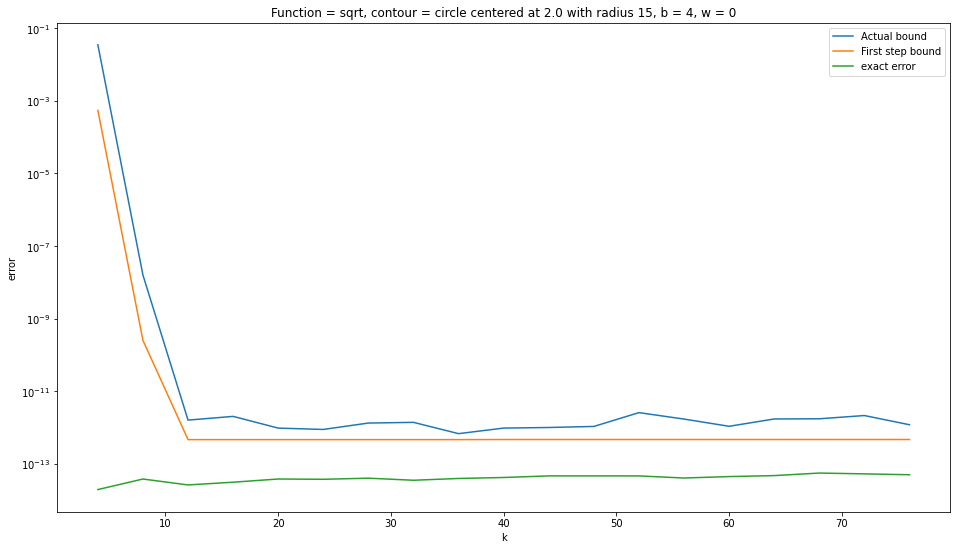

In [36]:
block_mid = np.full(K,np.inf)
block_exact = np.full(K,np.inf)
block_bound = np.full(K,np.inf)
breakval = int((K+1)/step)

for k in range(1,(K+1)//step):
    k = step*k
#     unit is the number of rows/cols of Q and T to pass to the bound-finding-methods.
    unit = k*b
    
    block_mid[(k-1)//step] = block_a_posteriori_bound_mid(T[:unit, :unit], f,Gamma,[0,np.pi], Q[:, :unit], H, V, B_0)
    block_exact[(k-1)//step] = block_a_posteriori_bound_exact(T[:unit, :unit], f,H, V,Q[:, :unit], B_0, b)
    block_bound[(k-1)//step] = block_a_posteriori_bound(T[:unit, :unit], f,Gamma,[0,np.pi],w,lmin,lmax, k, B_0)
    
#     stop the algorithm once the error reaches a satisfying level. 
#     if block_bound[(k-1)//step] < thresh:
#         breakval = (k-1)//step
#         break

x = np.linspace(1, K, K)
plt.plot(x*step, np.abs(block_bound), label = "Actual bound")
plt.plot(x*step, np.abs(block_mid), label = "First step bound")
plt.plot(x*step, np.abs(block_exact), label = "exact error")

title = "Function = " + funcName + ", contour = " + contourName + ", b = " + str(b) + ", w = " + str(w)
plt.title(title)
plt.yscale('log')
plt.xlabel("k")
plt.ylabel("error")
plt.legend()

if saveFig:
    plt.savefig('figure/' + title + ".png")
plt.show()

In [29]:
w = 10

mid = block_a_posteriori_bound_mid(T, f, Gamma, [0,np.pi], Q, H, V, B_0)
exact = block_a_posteriori_bound_exact(T, f, H, V, Q, B_0, b)
bound = block_a_posteriori_bound(T, f, Gamma, [0,np.pi], w, lmin, lmax, k, B_0)
print("removable error = " + str(np.abs(bound - mid)))
print("nonremovable error = " + str(np.abs(mid - exact)))
print("overall error = " + str(np.abs(exact - bound)))

removable error = 1.7767887234492632e-15
nonremovable error = 4.5739740020248714e-14
overall error = 4.751652874369798e-14


# Below is a script that plots a set of plots defined above for a set of different functions.

In [12]:
# def inverse(x):
#     return 1/x
# def sqrt(x):
#     return np.sqrt(x)
# def exponential(x):
#     return np.exp(x)

# functions = [inverse, sqrt, exponential]
# funcNames = ["inverse", "sqrt", "exponential"]
# saveFig = True
# for b in [1, 2, 4]:
#     V = np.random.randn(n,b)
    
#     Q,Qkp1,A,B,B_0 = BM.block_lanczos(H, V, K, K+1)

#     T = BM.get_block_tridiag(A,B)
#     EvalT, EvecT = np.linalg.eigh(T)

#     for i in np.arange(len(functions)):
#         f = functions[i]
#         funcName = funcNames[i]
    
#         block_mid = np.full(K,np.inf)
#         block_exact = np.full(K,np.inf)
#         block_bound = np.full(K,np.inf)

#         for k in range(1,int((K+1)/step)):
#             k = step*k
#             unit = k*b

#             block_mid[int((k-1)/step)] = block_a_posteriori_bound_mid(T[:unit, :unit], f,Gamma,[0,np.pi], Q[:, :unit], H, V, B_0)
#             block_exact[int((k-1)/step)] = block_a_posteriori_bound_exact(T[:unit, :unit], f,H, V,Q[:, :unit], B_0, b)
#             block_bound[int((k-1)/step)] = block_a_posteriori_bound(T[:unit, :unit], f,Gamma,[0,np.pi],w,lmin,lmax, k, B_0)

#             if block_bound[int((k-1)/step)] < thresh:
#                 break
                
#         x = np.linspace(1, K, K)

#         plt.plot(x*step, np.abs(block_bound), label = "Actual bound")
#         plt.plot(x*step, np.abs(block_mid), label = "First step bound")
#         plt.plot(x*step, np.abs(block_exact), label = "exact error")

#         title = "Function = " + funcName + ", contour = " + contourName + ", b = " + str(b) + ", w = " + str(w)
#         plt.title(title)
#         plt.yscale('log')
#         plt.xlabel("k")
#         plt.ylabel("error")
#         plt.legend()

#         if saveFig:
#             plt.savefig('figure/' + title + ".png")
#         plt.clf()

# Below is a script that (after fixing) finds the bests w values given a contour.

In [ ]:
n = 500 # matrix dimension
b = 4 # block size
K = 80 # max iter
thresh = 1e-10 # goal error

saveFig = False # whether to save generated figure or not

# set up matrix
lam = np.linspace(1e-2,1,n)
H = np.diag(lam)

# set up vector
V = np.random.randn(n,b)

# w value
w = 0

# how many iterations per sample for plotting
step = 4

Q,Qkp1,A,B,B_0 = BM.block_lanczos(H, V, K, K+1)

# generate tridiagonal matrix and get eigendecomp
T = BM.get_block_tridiag(A,B)
EvalT, EvecT = np.linalg.eigh(T)

lmin = np.min(lam)
lmax = np.max(lam)
kappa = lmax / lmin

lmin = lmin/2
lmax = 2*lmax

funcName = "sqrt"
# define function
def f(x):
    return np.sqrt(x)

contourName = "circle centered at " +str(lmax) + " with radius " + str(15)
# define contour
def Gamma(t):
    radius = 1.999995

    z = radius*np.exp(1j*t)+lmax
    dz = radius*1j*np.exp(1j*t)
    
    return z,dz

In [31]:
# w plane
x =  np.linspace(lmin-2, lmax+2, 10)
y =  np.linspace(-2, +2, 10)
X, Y = np.meshgrid(x, y)

In [14]:
blist = [1, 4]
wlist = []

for b_iter in range(len(blist)):
    
    b = blist[b_iter]
    V = np.random.randn(n,b)
    
    Q,Qkp1,A,B,B_0 = BM.block_lanczos(H, V, K, K+1)

    # generate tridiagonal matrix and get eigendecomp
    T = BM.get_block_tridiag(A,B)
    EvalT, EvecT = np.linalg.eigh(T)
    
    w = np.zeros((len(x), len(y)))

    print("0/" + str(len(x)*len(y)))
    for p in range(len(x)):
        for q in range(len(y)):
            this_w = x[p]+y[q]*1j

            w[p, q] = block_a_posteriori_bound(T, f, Gamma, [0,np.pi], this_w, lmin, lmax, K, B_0)
            w[p, q] = np.abs(w[p, q] - block_a_posteriori_bound_mid(T, f, Gamma,[0,np.pi], Q, H, V, B_0))

    #         progress indication
            clear_output(wait=True)
            print(str(len(x)*p+q+1) + "/" + str(len(x)*len(y)))
            
    wlist.append(w) 

100/100


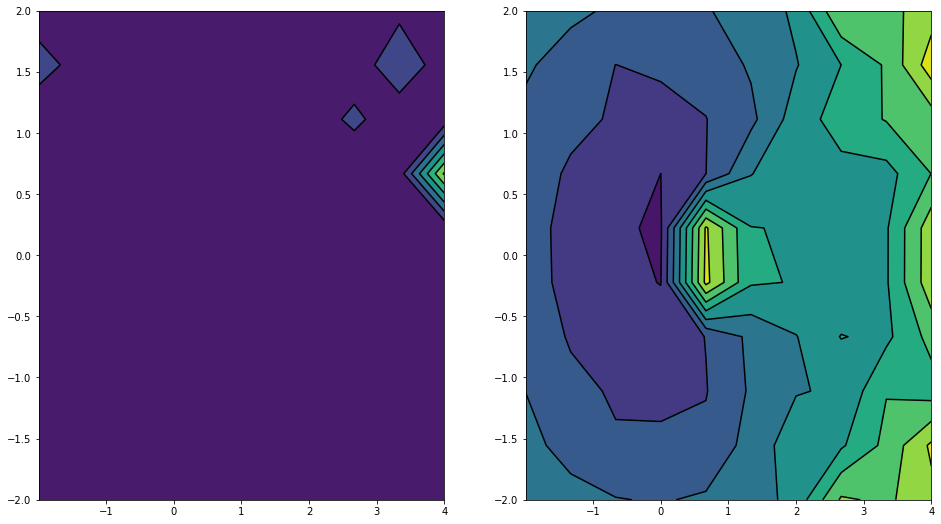

In [32]:
fig,ax = plt.subplots(1, 2, figsize=(16,9))
for b_iter in range(len(blist)):
    cp = ax[b_iter].contourf(X, Y, wlist[b_iter].T)
    rim = ax[b_iter].contour(X, Y, wlist[b_iter].T, colors = 'black')

# Below is the script that may suggest how to choose a contour given w.

In [16]:
w = 0
K = 10

# z plane
# maybe have grid change with w?
x =  np.linspace(lmin-22, lmax+22, 160)
y =  np.linspace(-22, +22, 80)
X, Y = np.meshgrid(x, y)

In [20]:
blist = [1, 4]
zlist = []

for b_iter in range(len(blist)):
    
    b = blist[b_iter]
    V = np.random.randn(n,b)
    
    oscTest(H, w)
    Q,Qkp1,A,B,B_0 = BM.block_lanczos(H, V, K, K+1)

    # generate tridiagonal matrix and get eigendecomp
    T = BM.get_block_tridiag(A,B)
    EvalT, EvecT = np.linalg.eigh(T)
    
    z = np.zeros((len(x), len(y)), dtype = "complex")
    for p in range(len(x)):
        for q in range(len(y)):
            clear_output(wait=True)
            this_z = x[p]+y[q]*1j

            z[p, q] = np.abs(f(this_z)) * np.linalg.norm(BM.get_CwinvCz(EvalT,EvecT,this_z,w,np.shape(B_0)[0],B_0), ord = 2) * Q_wz(w,this_z,lmin,lmax) * np.linalg.norm(exact_err(w, H, V, Q, T, B_0), ord = 2)
            z[p, q] /= np.linalg.norm(f(this_z)* exact_err(this_z, H, V, Q, T, B_0), ord = 2)
            z[p, q] = np.log(z[p, q])


            print(str(len(y)*p+q+1) + "/" + str(len(x)*len(y)))
    zlist.append(z) 

12800/12800


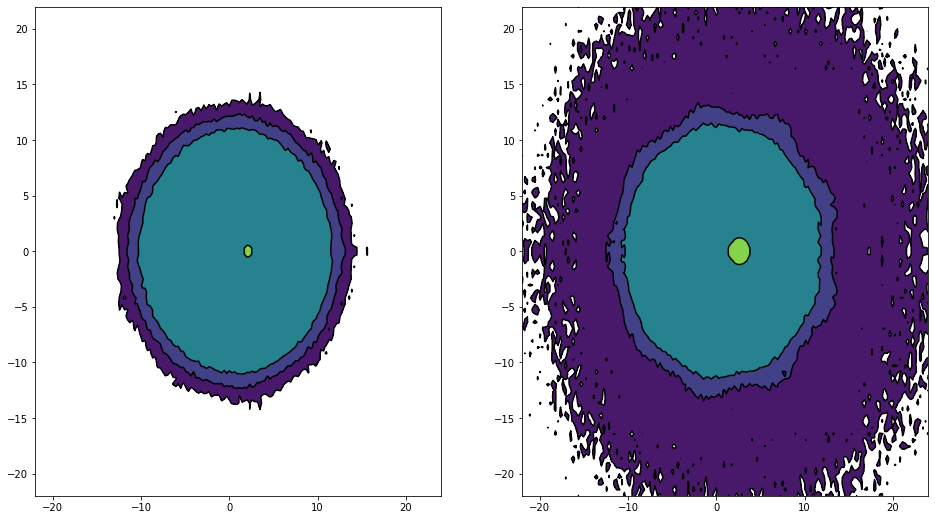

In [21]:
fig,ax = plt.subplots(1, 2, figsize=(16,9))
for b_iter in range(len(blist)):
    cp = ax[b_iter].contourf(X, Y, zlist[b_iter].T, [0, 1, 2, 5, 8])
    rim = ax[b_iter].contour(X, Y, zlist[b_iter].T, [0, 1, 2, 5, 8], colors = 'black')

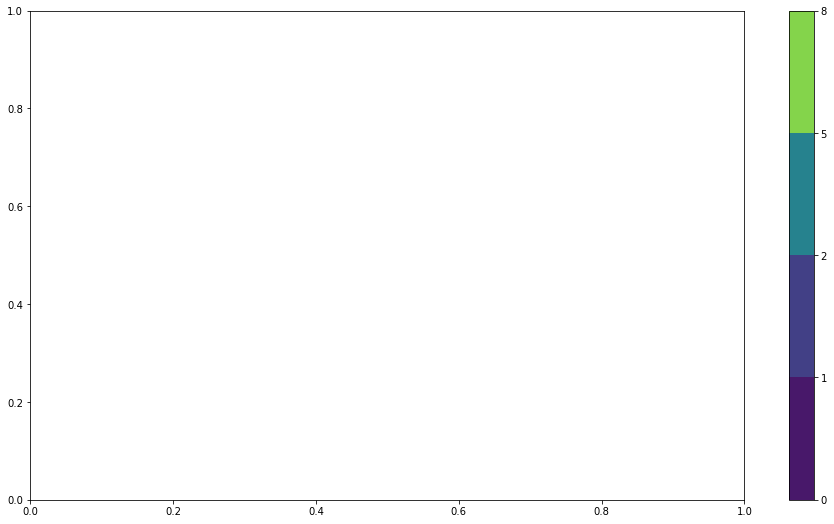

In [19]:
plt.colorbar(cp)